In [ ]:
!wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
!unzip -q lol_dataset.zip && rm lol_dataset.zip

--2024-03-11 13:06:23--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/09/d909ef7668bb417b7065a311bd55a3084cc83a1f918e13cb41c5503328432db2/419fddc48958cd0f5599939ee0248852a37ceb8bb738c9b9525e95b25a89de9a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27lol_dataset.zip%3B+filename%3D%22lol_dataset.zip%22%3B&response-content-type=application%2Fzip&Expires=1710421583&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDQyMTU4M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS8wOS9kOTA5ZWY3NjY4YmI0MTdiNzA2NWEzMTFiZDU1YTMwODRjYzgzYTFmOTE4ZTEzY2I0MWM1NTAzMzI4NDMyZGIyLzQxOWZkZGM0ODk1OGNkMGY1NTk5OTM5ZWUwMjQ4

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

train_dir = "/content/lol_dataset/our485/low/"
test_dir = "/content/lol_dataset/eval15/low/"
output_dir = "/content/"

def resize_image(image_path, output_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, output_size)
    img = img / 255.0
    return img

def process_dataset(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    images = []
    for filename in os.listdir(input_dir):
        if filename.endswith(".png"):
            img_path = os.path.join(input_dir, filename)
            img = resize_image(img_path)
            images.append(img)
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, img)
    return images

train_images = process_dataset(train_dir, os.path.join(output_dir, "train"))
test_images = process_dataset(test_dir, os.path.join(output_dir, "test"))

In [ ]:
split = (2*len(train_images))//10
val_images = train_images[:split]
train_images = train_images[split:]

print(f"Training Size: {len(train_images)}")
print(f"Validation Size: {len(val_images)}")

Training Size: 388
Validation Size: 97


In [ ]:
import tensorflow as tf

train_images_tensor = tf.constant(train_images)
val_images_tensor = tf.constant(val_images)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images_tensor)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images_tensor)

batch_size = 16
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

print("Train Data Elements:", train_dataset.element_spec)
print("Validation Data Elements:", val_dataset.element_spec)

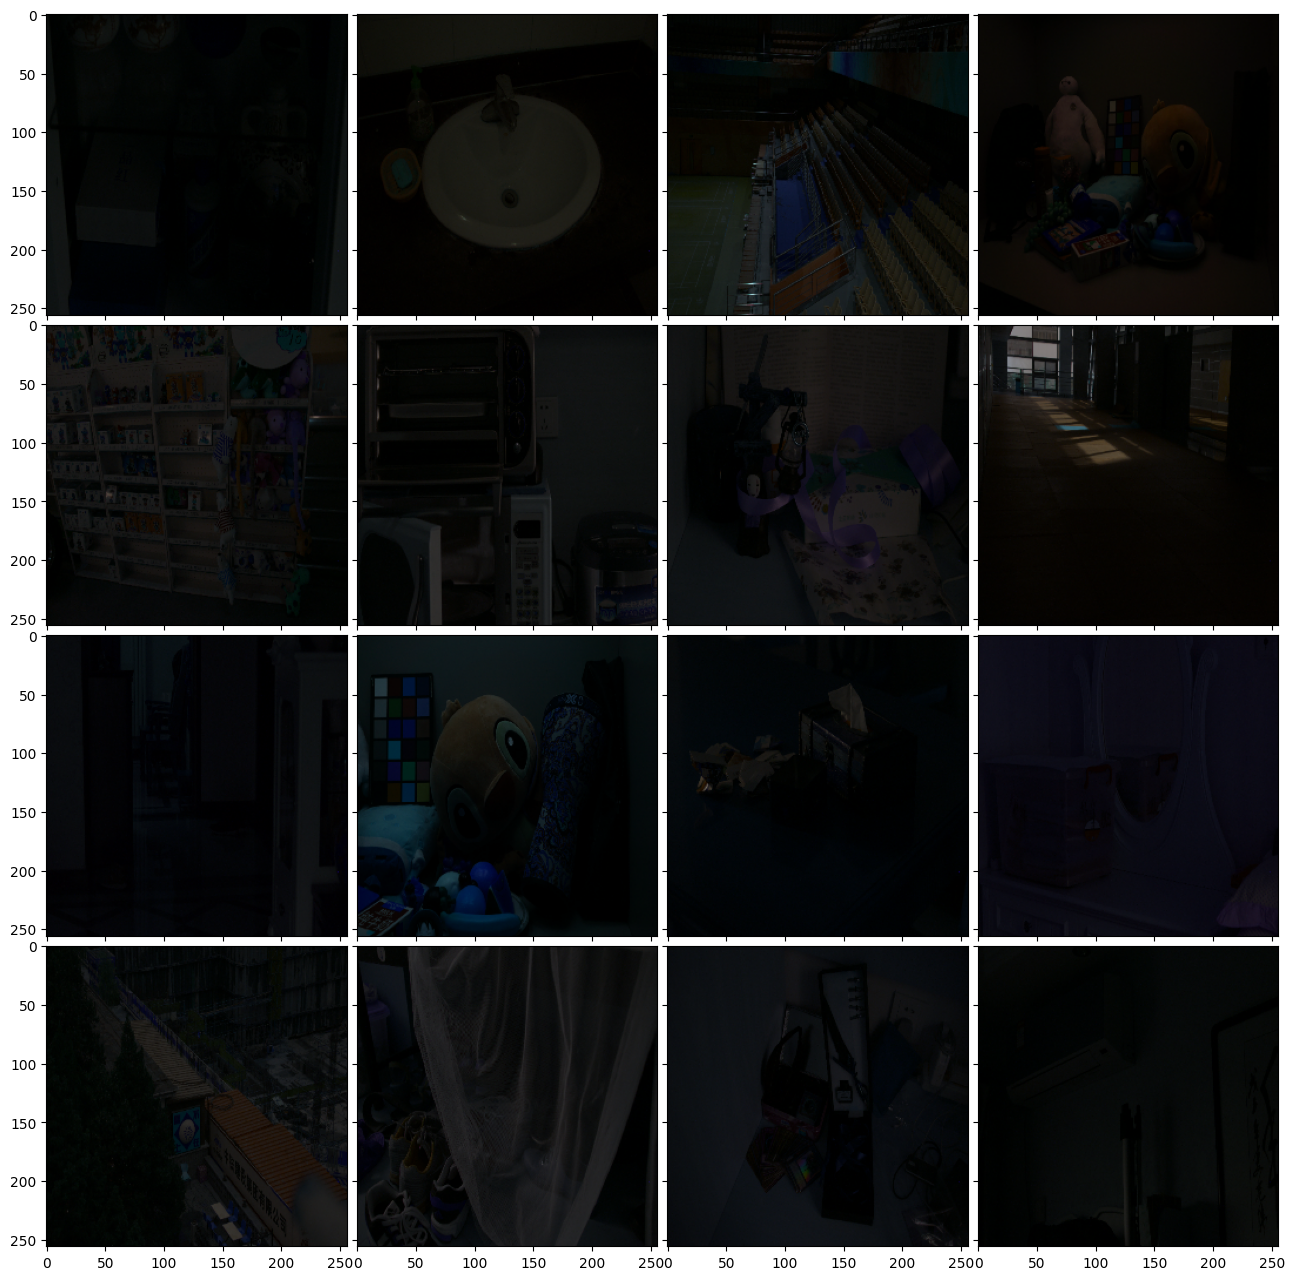

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

images = next(iter(train_dataset)).numpy()
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, images):
    image = image * 255.0
    ax.imshow(image.astype(np.uint8))
plt.title("Sample Images from Tiny-NeRF Data")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, callbacks

def build_dce_net(image_size=None) -> keras.Model:
    input_image = keras.Input(shape=[image_size, image_size, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_image)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_image, outputs=x_r)

In [ ]:
def color_constancy_loss(image):
    R = image[..., 0:1]
    G = image[..., 1:2]
    B = image[..., 2:3]

    pairs = [(R, G), (R, B), (G, B)]

    loss = 0
    for pair in pairs:
        diff = pair[0] - pair[1]
        loss += tf.reduce_mean(tf.square(diff))

    return tf.sqrt(loss)

In [ ]:
def exposure_loss(image, mean_val=0.6):
    image = tf.reduce_mean(image, axis=3, keepdims=True)
    image_patches = tf.image.extract_patches(image, sizes=[1, 16, 16, 1], strides=[1, 16, 16, 1], rates=[1, 1, 1, 1], padding='VALID')
    mean_patches = tf.reduce_mean(image_patches, axis=(1, 2, 3), keepdims=True)
    return tf.reduce_mean(tf.square(mean_patches - mean_val))

In [ ]:
def illumination_smoothness_loss(image):
    batch_size = tf.shape(image)[0]
    height_image = tf.shape(image)[1]
    width_image = tf.shape(image)[2]
    count_height = (tf.shape(image)[2] - 1) * tf.shape(image)[3]
    count_width = tf.shape(image)[2] * (tf.shape(image)[3] - 1)
    height_total_variance = tf.reduce_sum(
        tf.square((image[:, 1:, :, :] - image[:, : height_image - 1, :, :]))
    )
    width_total_variance = tf.reduce_sum(
        tf.square((image[:, :, 1:, :] - image[:, :, : width_image - 1, :]))
    )
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_height = tf.cast(count_height, dtype=tf.float32)
    count_width = tf.cast(count_width, dtype=tf.float32)
    return 2 * (
        height_total_variance / count_height + width_total_variance / count_width
    ) / batch_size

In [ ]:
class SpatialConsistencyLoss(losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        original_pool = tf.cast(original_pool, tf.float32)
        enhanced_pool = tf.cast(enhanced_pool, tf.float32)

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def summary(self, *args, **kwargs):
        self.dce_model.summary(*args, **kwargs)

    def get_enhanced_image(self, data, output):
        x = tf.cast(data, tf.float32)
        for i in range(0, 3 * 8, 3):
            r = output[:, :, :, i: i + 3]
            x = x + r * (tf.square(tf.cast(x, tf.float32)) - tf.cast(x, tf.float32))
        return x


    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image[:, :, :3] if image.shape[-1] > 3 else image
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [ ]:
import random
from PIL import Image, ImageOps

LEARNING_RATE = 1e-4
LOG_INTERVALS = 10
EPOCHS = 100

zero_dce_model = ZeroDCE()
zero_dce_model.summary()

zero_dce_model.compile(learning_rate=LEARNING_RATE)
history = zero_dce_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
)

# Save the model weights
zero_dce_model.save_weights("zero_dce_model_weights.h5")


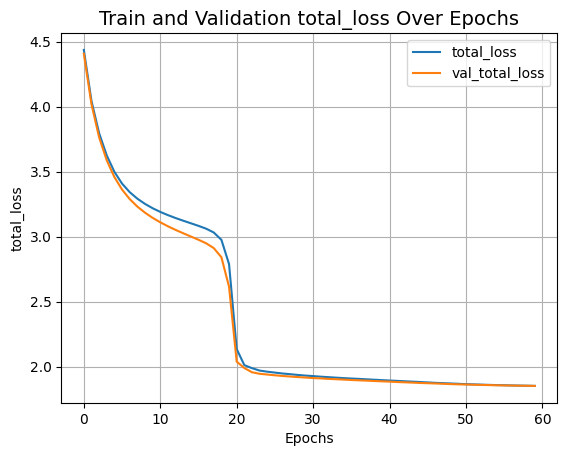

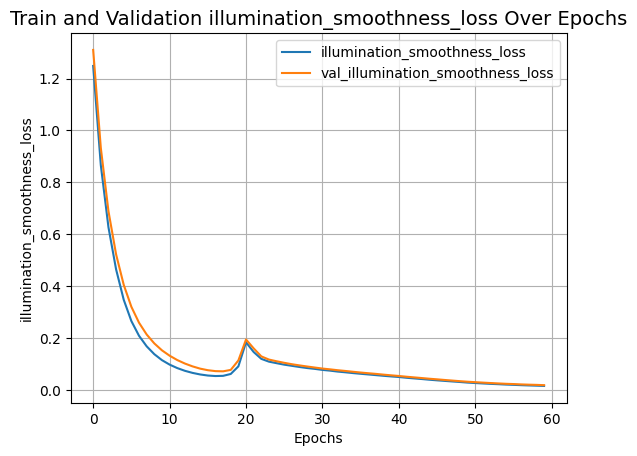

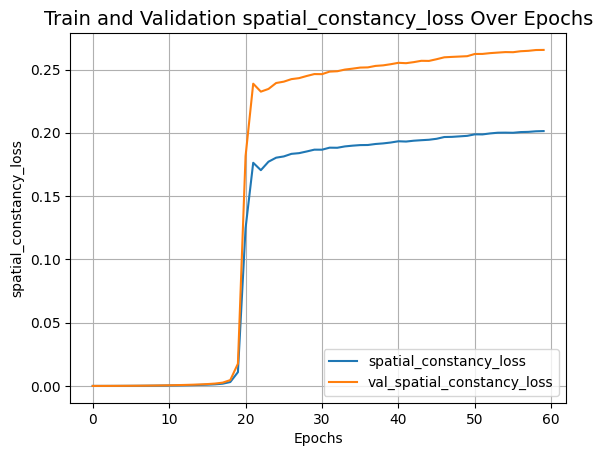

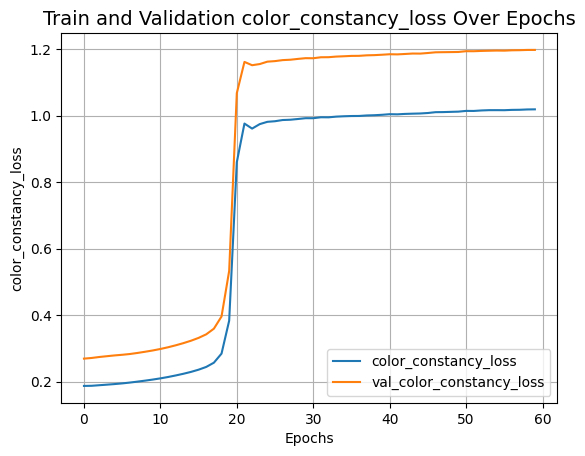

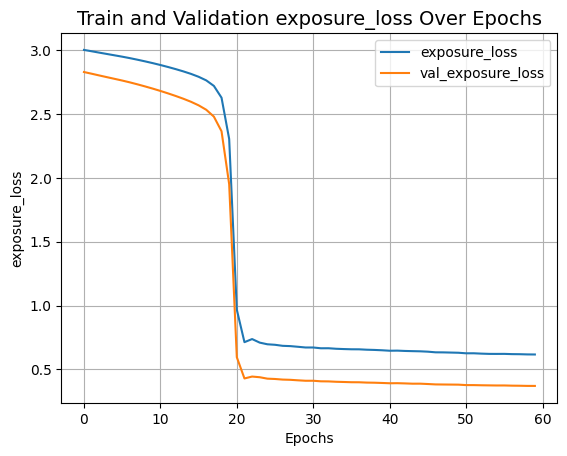

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [ ]:
import os
from PIL import Image

for filename in os.listdir(test_dir):
    if filename.endswith(".png"):
        val_image_file = os.path.join(test_dir, filename)
        original_image = Image.open(val_image_file)
        enhanced_image = infer(original_image)
        plot_results(
            [original_image, ImageOps.autocontrast(original_image), enhanced_image],
            ["Original", "PIL Autocontrast", "Enhanced"],
            (20, 12),
        )

In [ ]:
from PIL import Image
import numpy as np
import cv2

loaded_model = ZeroDCE()
loaded_model.load_weights("/content/zero_dce_model_weights.h5")

image_path = "/content/HD-wallpaper-saitama-one-punch-man-manga-hero-sensei-anime.jpg"

original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
image_array = np.array(original_image)
image_array = image_array / 255.0
image_array = np.expand_dims(image_array, axis=0)
enhanced_image = loaded_model.predict(image_array)
enhanced_image = Image.fromarray(np.uint8(enhanced_image[0] * 255))


# Save the enhanced image
enhanced_image.save("enhanced_image.jpg")


1/1 [==============================] - 7s 7s/step
